In [1]:
# This code cell imports stuff, etc.

import numpy as np
import matplotlib.pyplot as plt
from time import time as tm
import seaborn as sns

# Import local functions and params
from utils import *
from SpikingNetworkModels import EIFNetworkSim
from DefaultParams import *


print('rBal = ',1000*rBal[0],1000*rBal[1],'Hz')


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
rBal =  5.823529411764702 15.882352941176466 Hz


In [2]:
# This code cell creates connectivity, stimulus, and runs sims

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    
# Get connectivity matrix
J=GetBlockErdosRenyi(Ns,Jm,P,Ns)

# External input on top of baseline
X=np.zeros((StimDim,Nt))
for j in range(StimDim):
  X[j,:]=MakeSmoothGaussianProcess(taustim,Nt,dt)
Jx=sigmastim*np.random.rand(N,StimDim)

maxns=int(.05*Ne*Nt)+1
Ierecord=[0,1,2]
t0=tm()
se,si,VeRec = EIFNetworkSim(J,Jx,X,X0,Ne,NeuronParams,tau,Nt,dt,maxns,Ierecord)
tSim=tm()-t0
print('Time for sim:',tSim,'s')
se=se[:,se[0,:]>=0]
si=si[:,si[0,:]>=0]


# Store rates for this trial
AllERates=np.histogram(se[1,se[0,:]>=Tburn],bins = range(Ne+1))[0]/(T-Tburn)
AllIRates=np.histogram(si[1,si[0,:]>=Tburn],bins = range(Ni+1))[0]/(T-Tburn)

MeanERates=AllERates.mean()
MeanIRates=AllIRates.mean()

print('rSim =',1000*MeanERates,1000*MeanIRates,'Hz')


Time for sim: 37.095458984375 s
rSim = 5.3485000000000005 14.363692307692308 Hz


2338 of 4000 E neurons made the cut.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Mean EE corr: 0.005148574727096613
Std EE corr: 0.1837690351910666
Mean connected EE corr: 0.012625740946730964
Mean unconnected EE corr: 0.004317465242139766


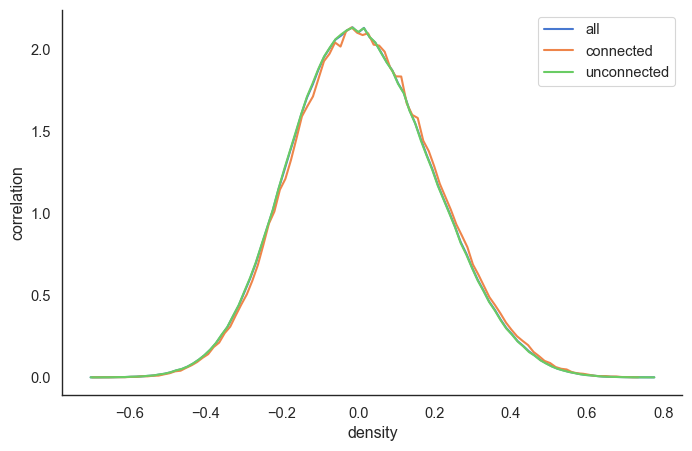

In [3]:
import seaborn as sns

sns.set(context='paper',style='white',font_scale=1.2,rc={"lines.linewidth":1.5})
sns.set_palette('muted')
#%config InlineBackend.figure_format = 'retina'


winsize=250.0
rmin=1.0/1000
ECounts=GetSpikeCounts(se,winsize,Ne,T)
ECounts=ECounts[:,:-int(3000/winsize)]

ECutoffInds=np.where(ECounts.sum(axis=1)>T*rmin)[0]
print(len(ECutoffInds),'of',Ne,'E neurons made the cut.')
CutoffEECorrMatrix=np.corrcoef(ECounts[ECutoffInds])
AllEECorrs = CutoffEECorrMatrix[np.triu_indices_from(CutoffEECorrMatrix,k=1)]


Jee=J[:Ne,:Ne]
JeeCutoff=Jee[ECutoffInds,:][:,ECutoffInds]
ConnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(JeeCutoff,k=1))]
UnconnectedEECorrs=CutoffEECorrMatrix[np.where(np.triu(np.logical_not(JeeCutoff),k=1))]

print('Mean EE corr:',AllEECorrs.mean())
print('Std EE corr:',AllEECorrs.std())

print('Mean connected EE corr:',ConnectedEECorrs.mean())
print('Mean unconnected EE corr:',UnconnectedEECorrs.mean())



hAllEE,bAllEE=np.histogram(AllEECorrs,100,density=True)
hConnEE,bConnEE=np.histogram(ConnectedEECorrs,100,density=True)
hUnconnEE,bUnconnEE=np.histogram(UnconnectedEECorrs,100,density=True)

plt.figure(figsize=(8,5))
plt.plot(bAllEE[1:],hAllEE, label='all')
plt.plot(bConnEE[1:],hConnEE, label='connected')
plt.plot(bUnconnEE[1:],hUnconnEE, label='unconnected')
plt.xlabel('density')
plt.ylabel('correlation')
plt.legend(loc='best')
sns.despine()
